In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import time
from scipy.special import expit, logit
import warnings
import joblib
import pickle
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
import json
from datetime import datetime

data_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/soil_property_model_pipeline'
prop_list = ['soc','ocd', 'bulk.density.fe','ph.cacl2', 'ph.h2o','total.n', 'carbonates', 
             'extractable.p', 'extractable.k','cec'] #'coarse.mass', 'coarse.vol', 'bulk.density.tot', 'ec', 

space_list = ['log1p','log1p','normal','normal','normal','log1p','log1p','log1p','log1p','log1p'] 
version = '20250212'


# Model evaluation
### generate predictions for evaluation

In [2]:
from sklearn.model_selection import LeaveOneGroupOut,GroupKFold,cross_val_predict

for ii in [1]:#range(0,len(prop_list)):
    # define metadata------------------------------------------------------------
    prop = prop_list[ii]
    ttprint(f'processing {prop}-----------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    # os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read in material--------------------------------------------------------------
    # data
    train = pd.read_parquet(f'{output_folder}/data_train_{prop}_v{version}.pq')
    test = pd.read_parquet(f'{output_folder}/data_test_{prop}_v{version}.pq')
    covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    test = test.dropna(subset=covs,how='any')
    train = train.dropna(subset=covs,how='any')
    
    # feature importance
    fi_df = pd.DataFrame(covs, columns=['feature'])
    
    # models
    model_list = find_files(data_path+f'/{prop}',f'*model*rf*{prop}*joblib')
    model_list = [str(i) for i in model_list]
    keep_col_cv = ['time', 'lat', 'lon', 'id', 'ref', 'nuts0', 'hzn_dep', 'lc_survey','tile_id', prop, tgt]
    keep_col_test = ['time', 'lat', 'lon', 'id', 'ref', 'nuts0', 'hzn_dep', 'lc_survey','tile_id', prop, tgt]
    for iii in range(len(model_list)):
        model = joblib.load(model_list[iii])
        model.n_jobs =90
        model_name = model_list[iii].split('_')[-2].split('.')[0]
    
        # cross validation------------------------------------------------------------
        # spatial cv
        cv = GroupKFold(n_splits=5) 
        ttprint(f'start spatial CV for {model_name}')
        y_scv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'])
        ttprint(f'finish temporal CV for {model_name}')
        train[f'{tgt}_cv.spatial_{model_name}'] = y_scv

        # temporal cv
        tgroups = train['time']
        logo = LeaveOneGroupOut()
        ttprint(f'\nstart temporal CV for {model_name}')
        y_tcv = cross_val_predict(model, train[covs], train[tgt], cv=logo.split(train[covs], train[tgt], tgroups))
        ttprint(f'finish temporal CV for {model_name}')
        train[f'{tgt}_cv.loyo_{model_name}'] = y_tcv

        # test---------------------------------------------------------------------------
        ttprint(f'start test prediction for {model_name}')
        model.fit(train[covs], train[tgt])
        y_val = model.predict(test[covs])
        ttprint(f'finish test prediction for {model_name}')
        test[f'{tgt}_test_{model_name}'] = y_val
        
        # variable importance
        # pfi = permutation_importance(model, test[covs], test[tgt], n_jobs=80, n_repeats=10, random_state=42)
        # fi_df[f'{model_name} permutation importance'] = pfi.importances_mean
        importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
        importance_df = importance_df.sort_values(by='importance', ascending=False)
        importance_df.to_csv(f'{output_folder}/feature_importance_{model_name}_v{version}.csv', index=False)
        
        keep_col_cv = keep_col_cv + [f'{tgt}_cv.loyo_{model_name}', f'{tgt}_cv.spatial_{model_name}']
        keep_col_test = keep_col_test + [f'{tgt}_test_{model_name}']
        
    # save
    # date_str = datetime.today().strftime('%Y%m%d')
    fi_df.to_csv(f'{output_folder}/feature_importance_v{version}.csv',index=False)
    train[keep_col_cv].to_csv(f'{output_folder}/prediction_cv_{prop}_v{version}.csv',index=False)
    test[keep_col_test].to_csv(f'{output_folder}/prediction_test_{prop}_v{version}.csv',index=False)

[10:19:06] processing ocd-----------------------------------
[10:19:06] start spatial CV for ccc
[10:19:18] finish temporal CV for ccc
[10:19:18] 
start temporal CV for ccc
[10:20:18] finish temporal CV for ccc
[10:20:18] start test prediction for ccc
[10:20:21] finish test prediction for ccc


### calculate metrics and plot accuracy figure

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict

# Use GroupKFold in one step within cross_val_predict
y_scv = cross_val_predict(model, train[covs], train[tgt], cv=GroupKFold(n_splits=5), groups=train[spatial_col])


[10:26:35] processing soc-----------------------------------
[10:26:37] processing ocd-----------------------------------
[10:26:39] processing bulk.density.fe-----------------------------------
[10:26:40] processing ph.cacl2-----------------------------------
[10:26:42] processing ph.h2o-----------------------------------
[10:26:44] processing total.n-----------------------------------
[10:26:45] processing carbonates-----------------------------------
[10:26:47] processing extractable.p-----------------------------------
[10:26:49] processing extractable.k-----------------------------------
[10:26:50] processing cec-----------------------------------


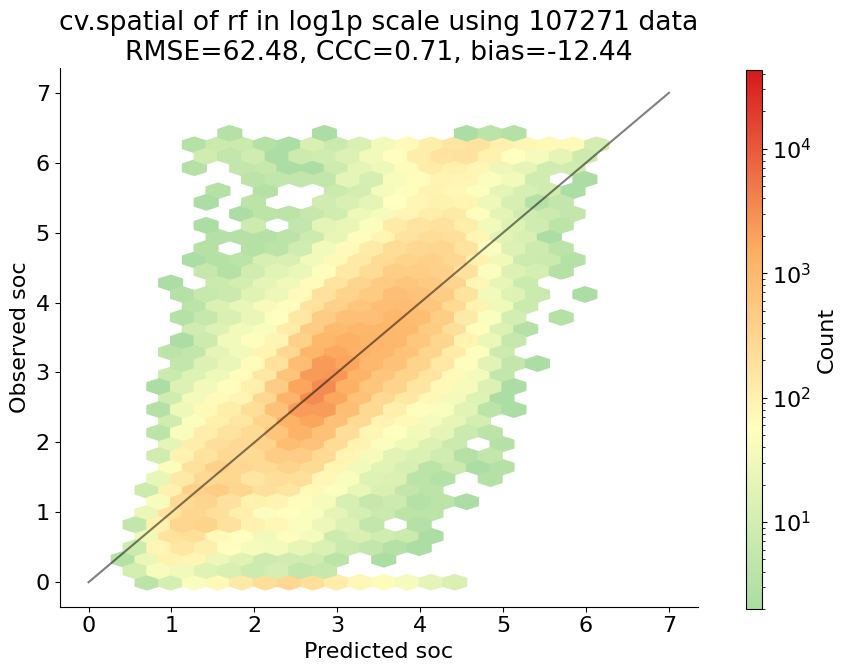

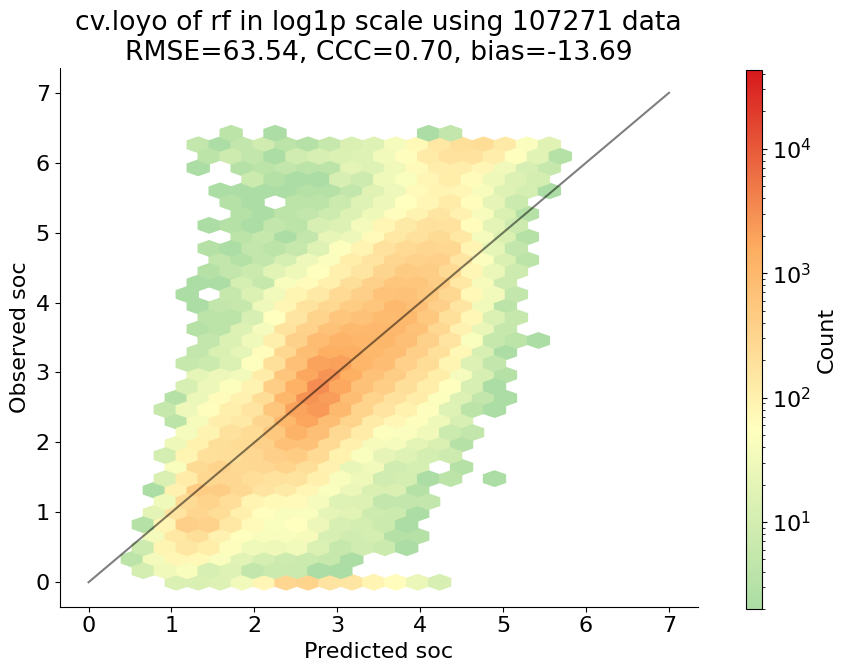

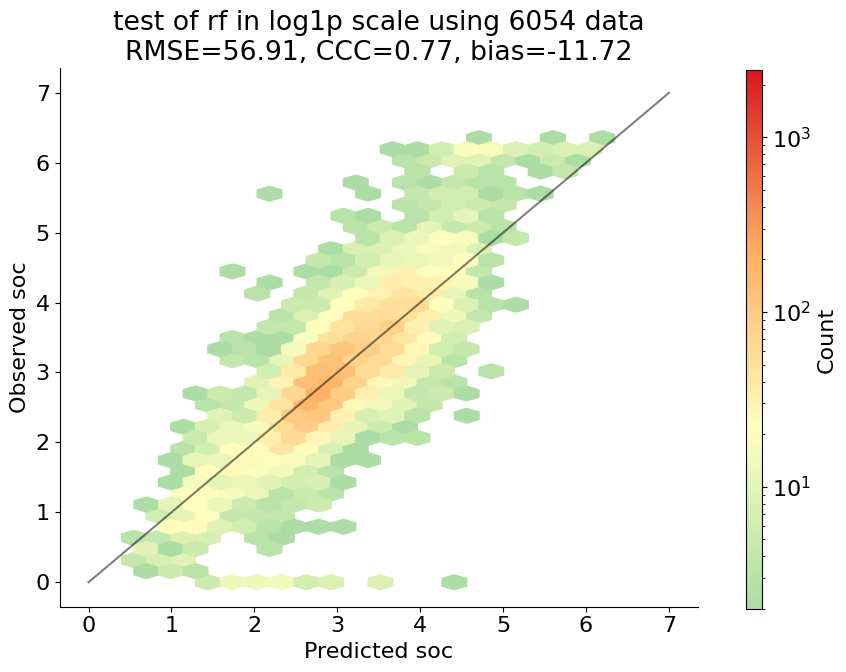

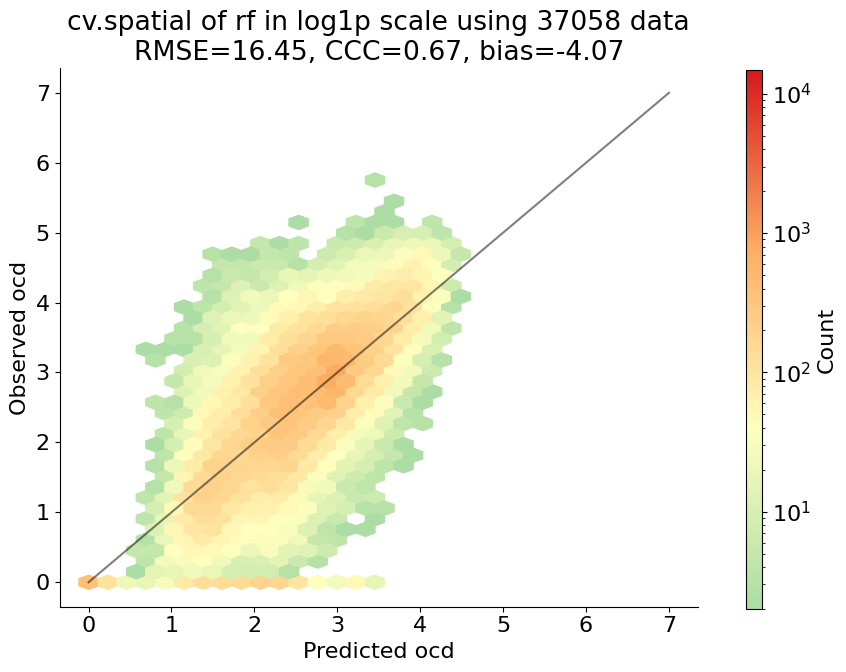

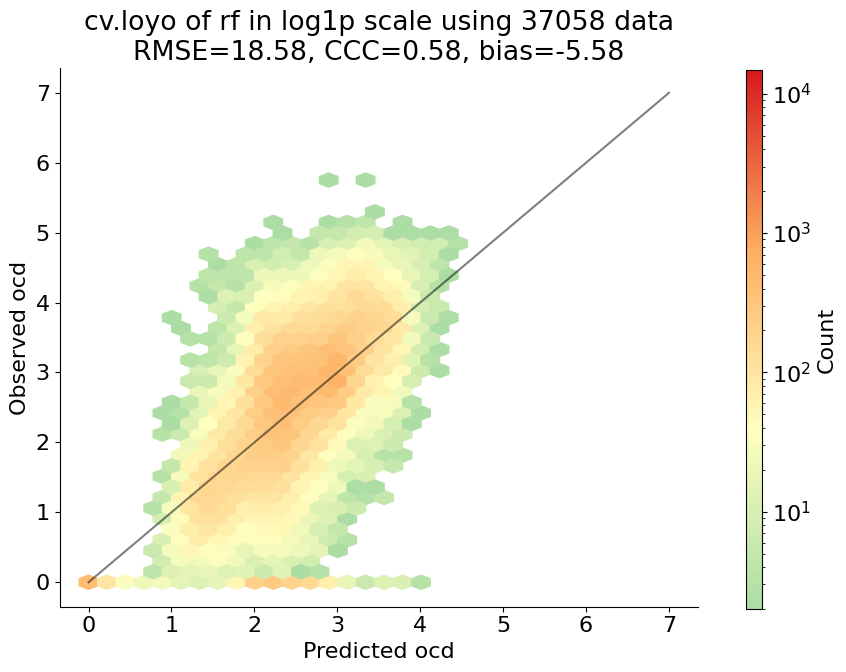

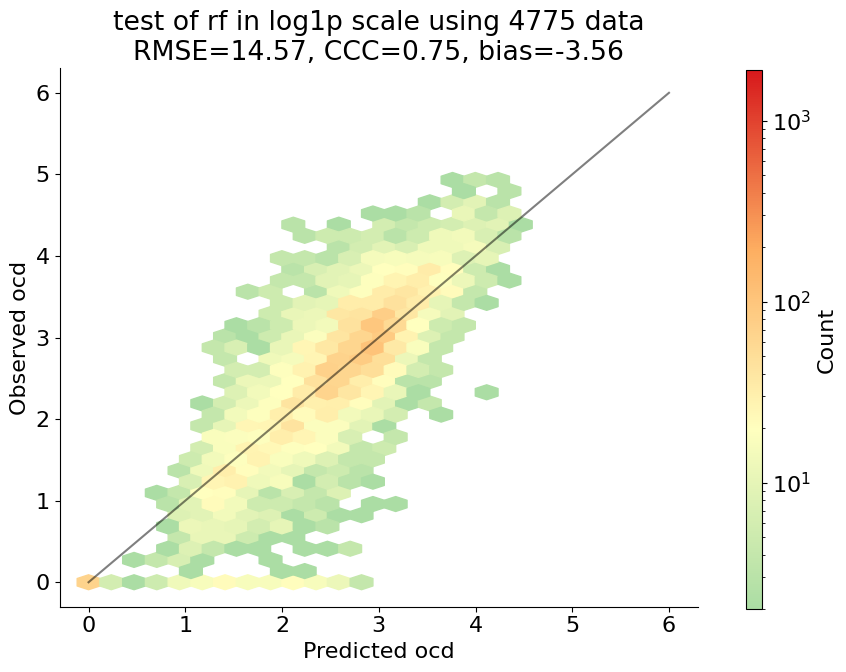

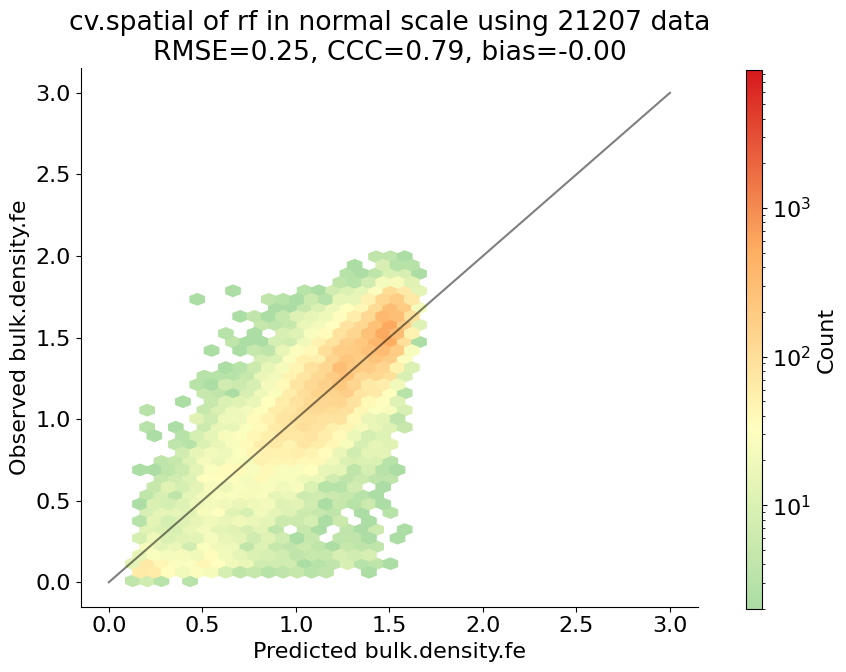

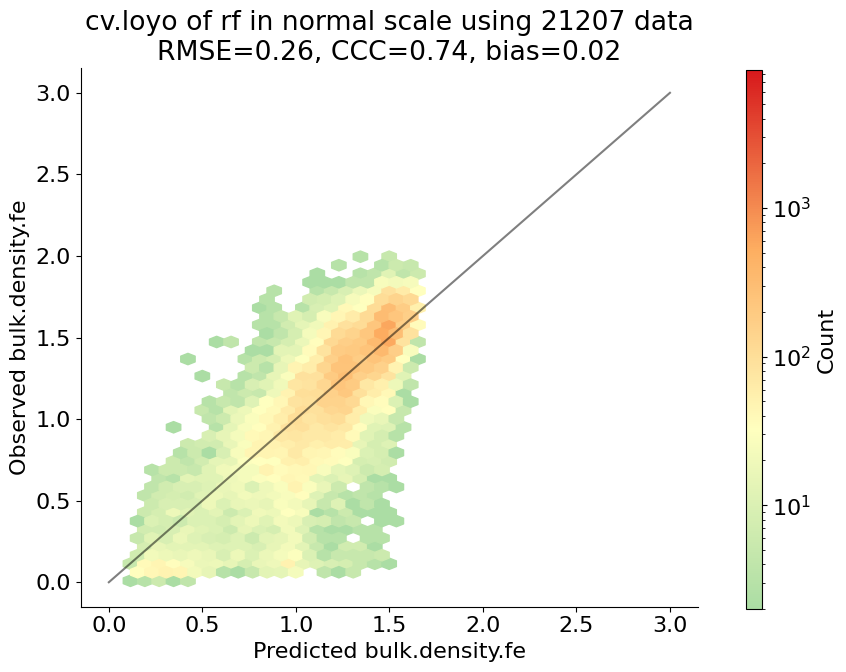

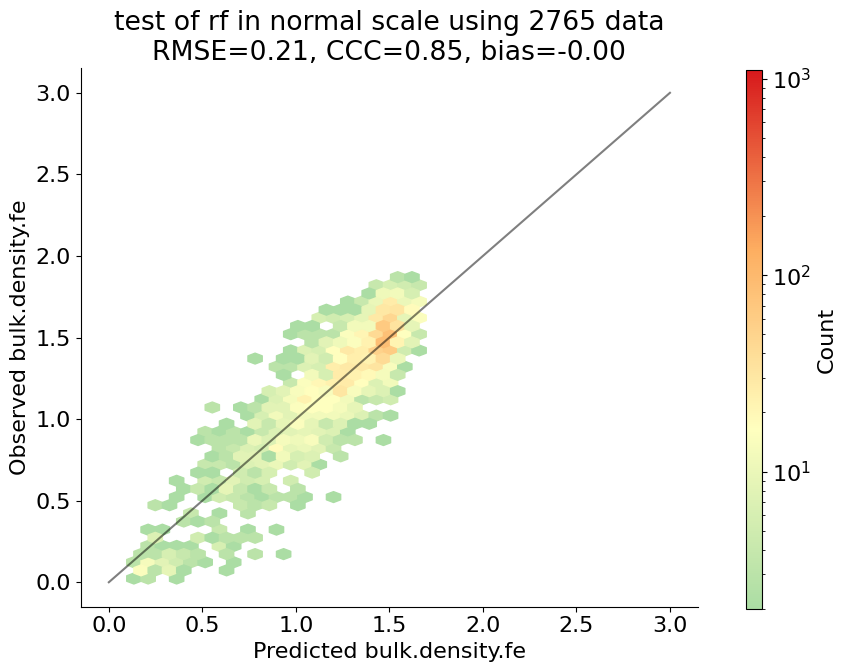

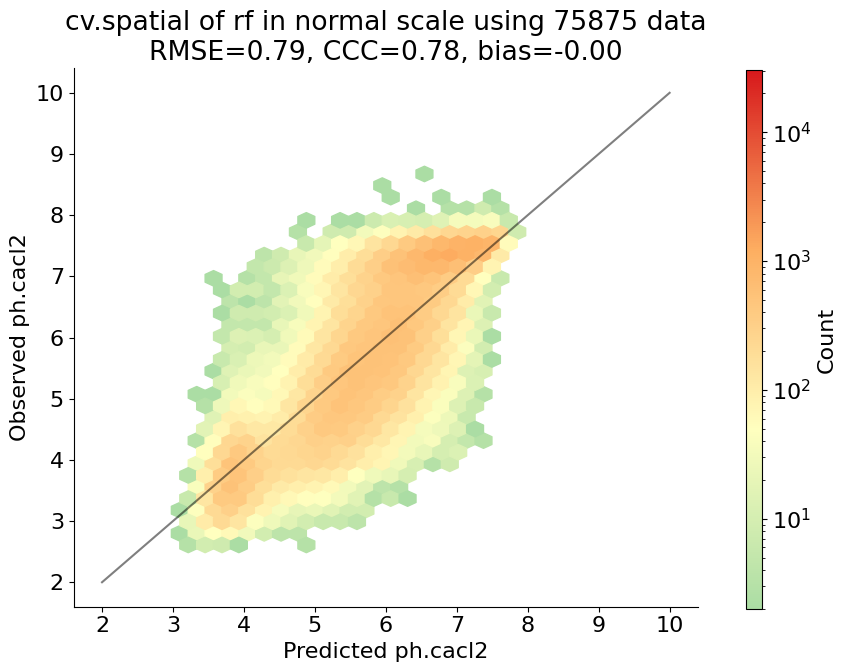

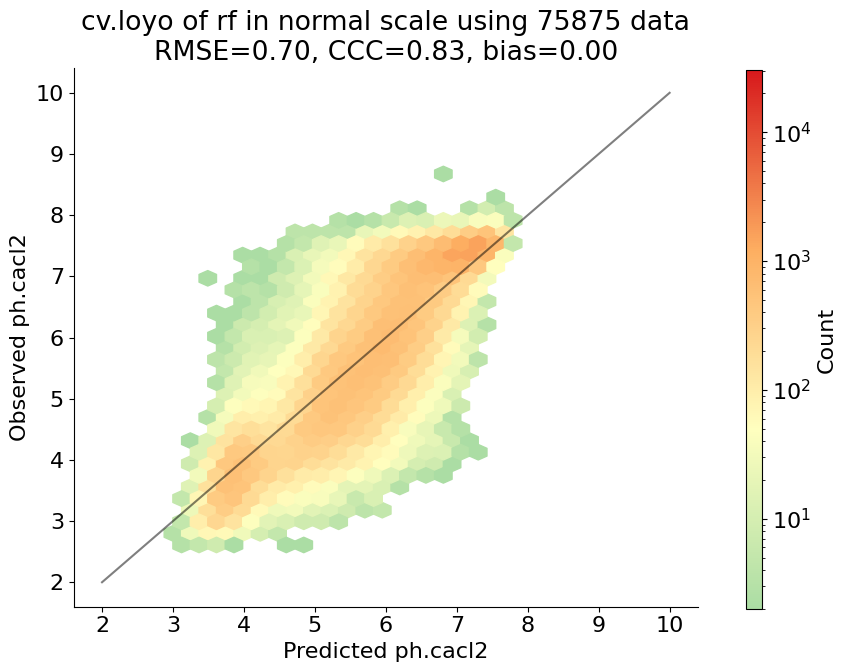

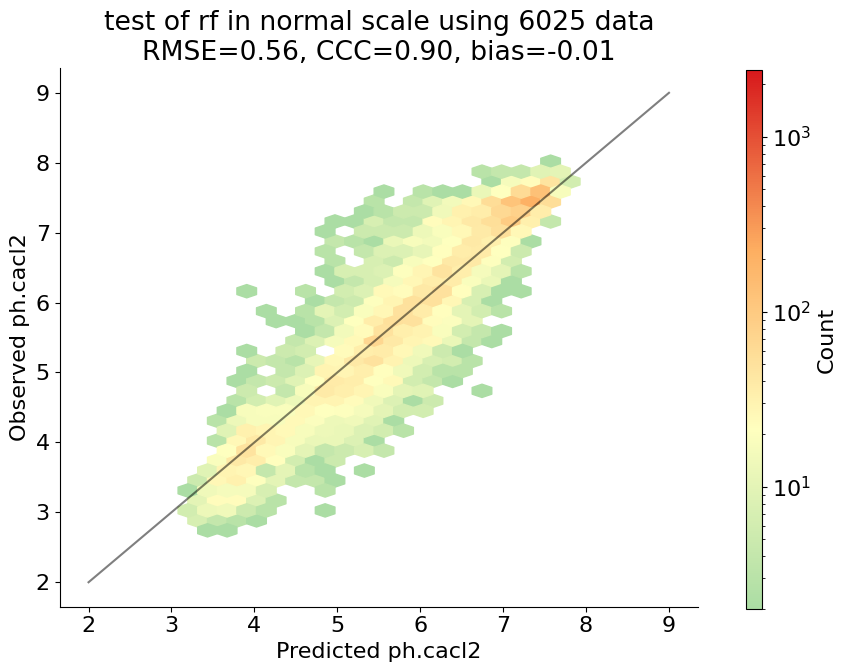

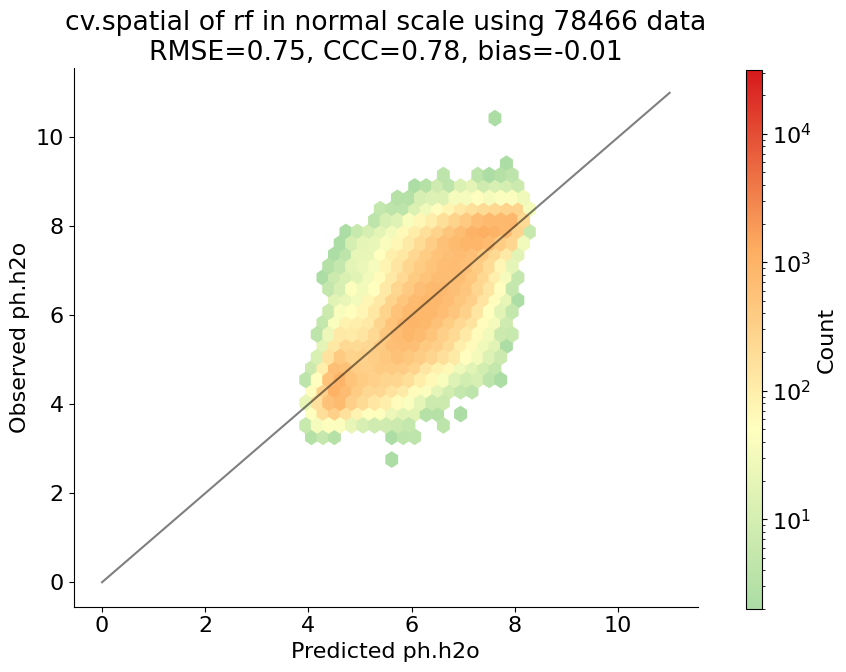

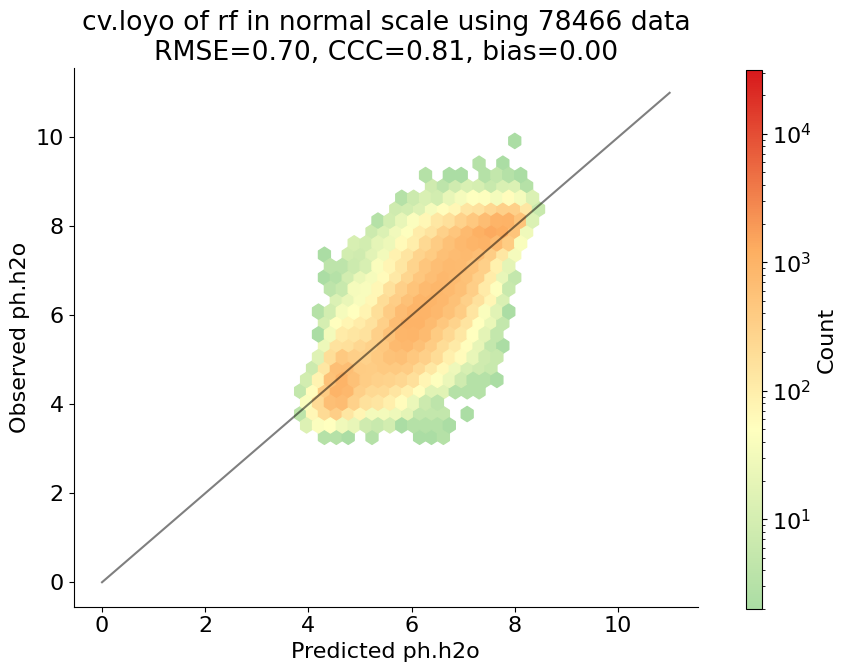

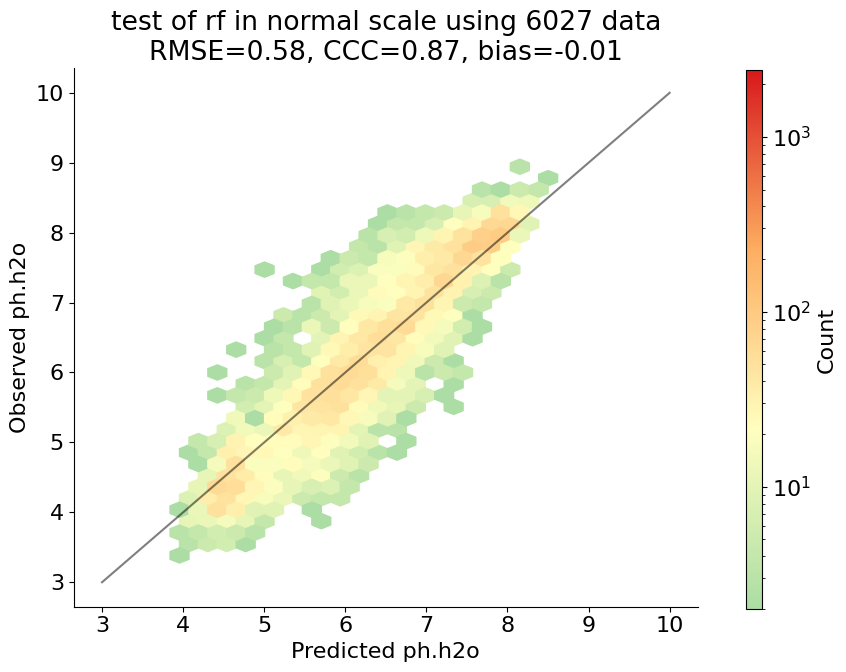

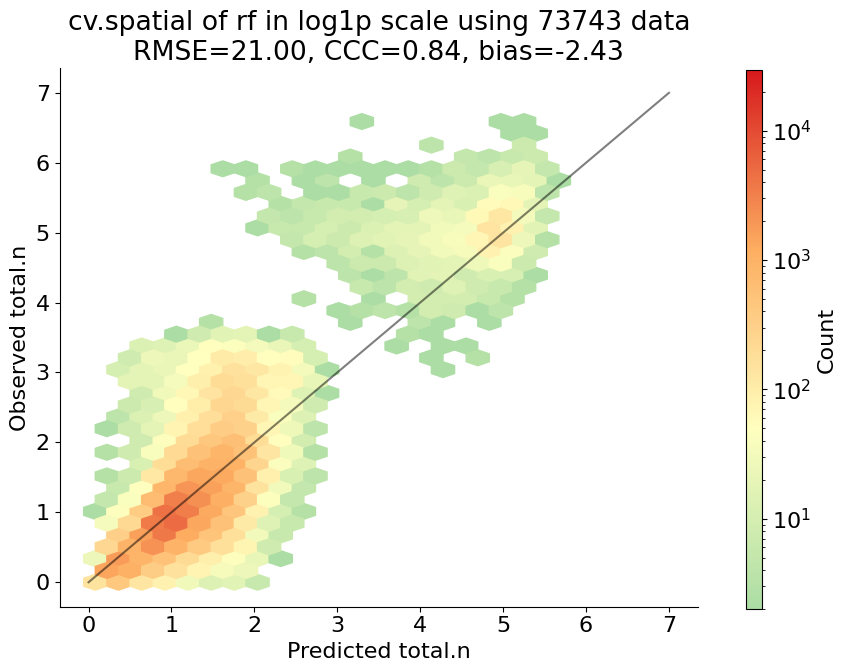

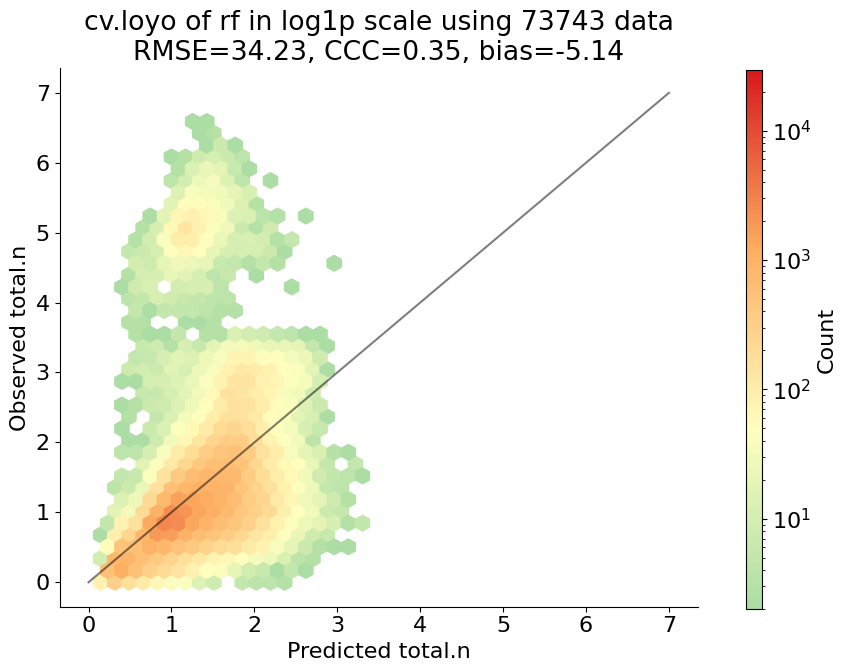

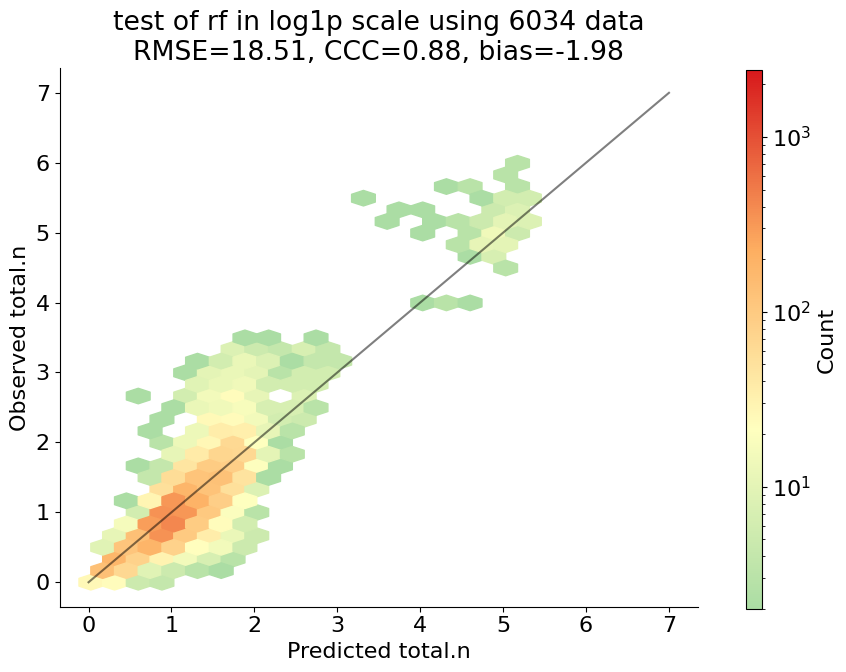

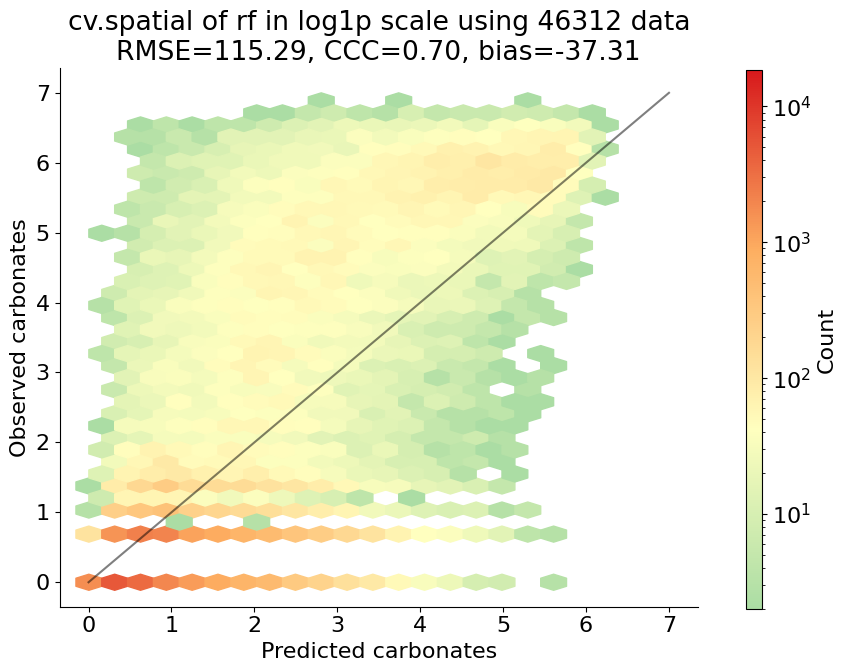

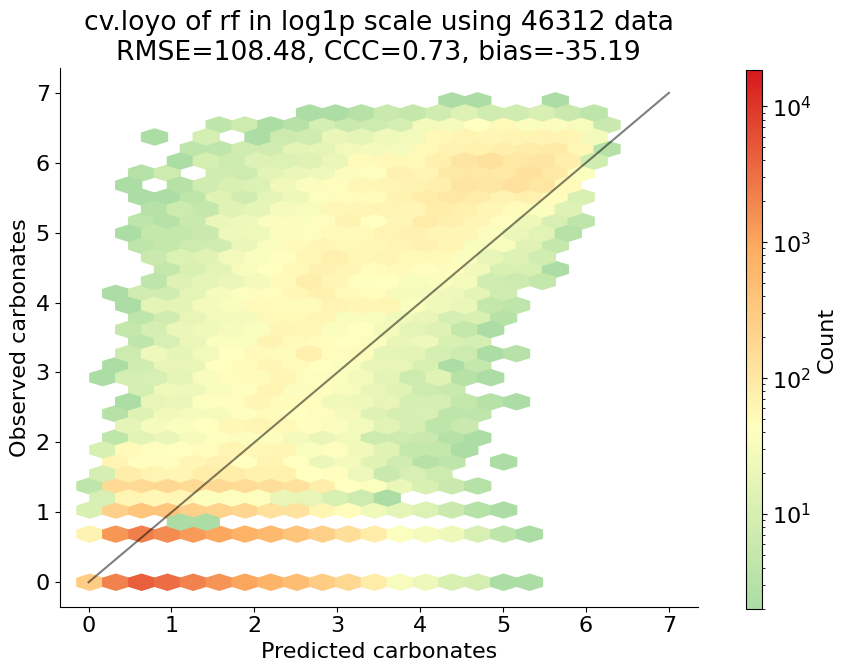

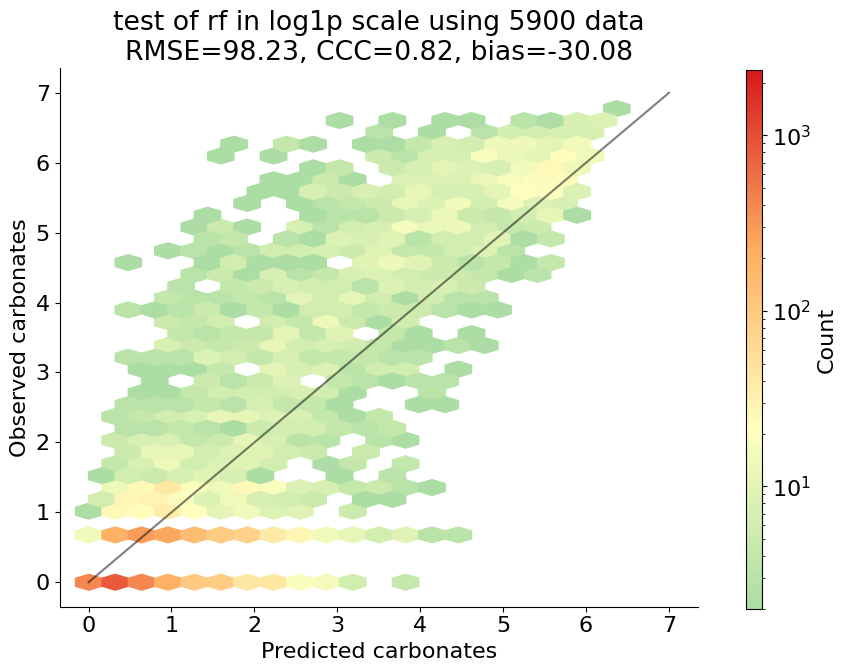

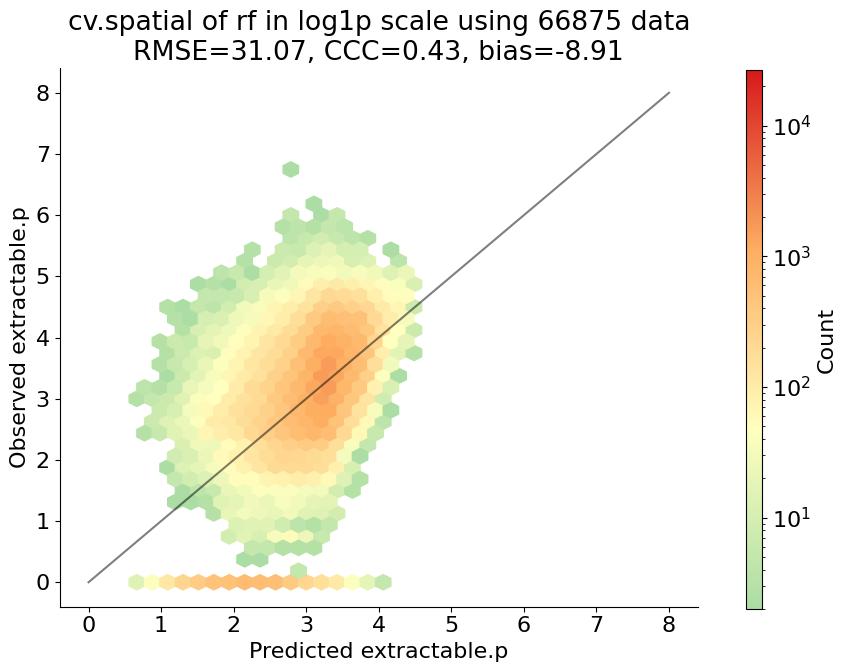

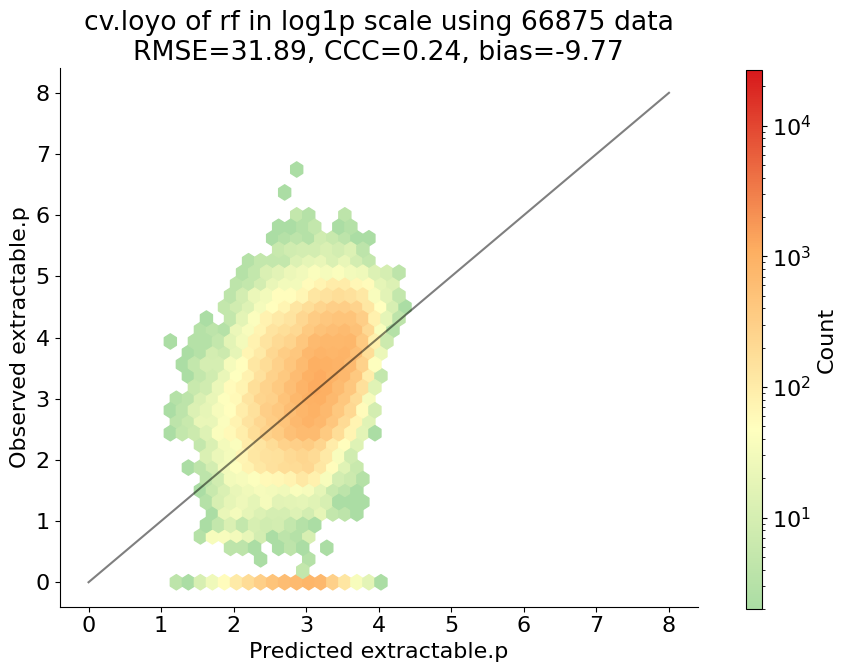

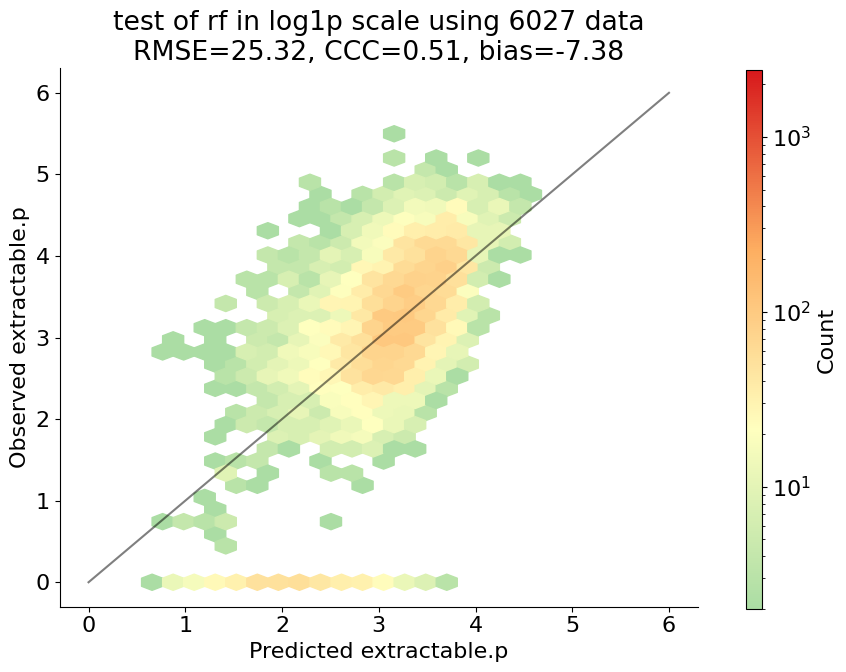

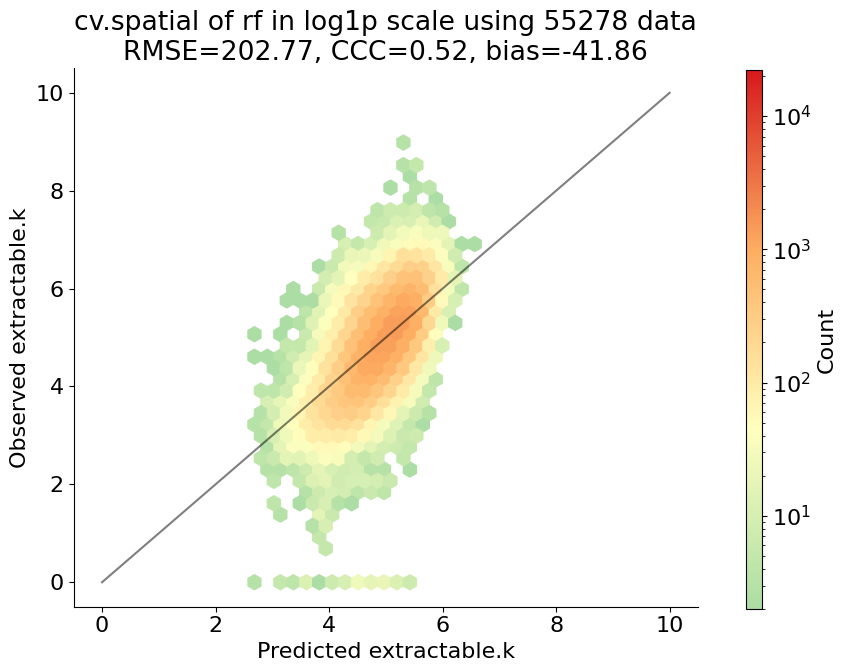

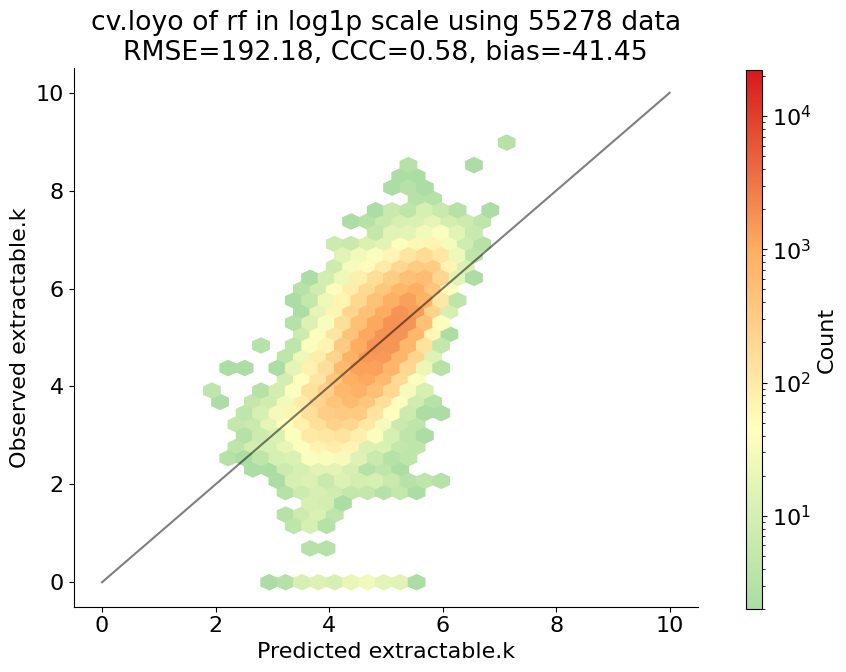

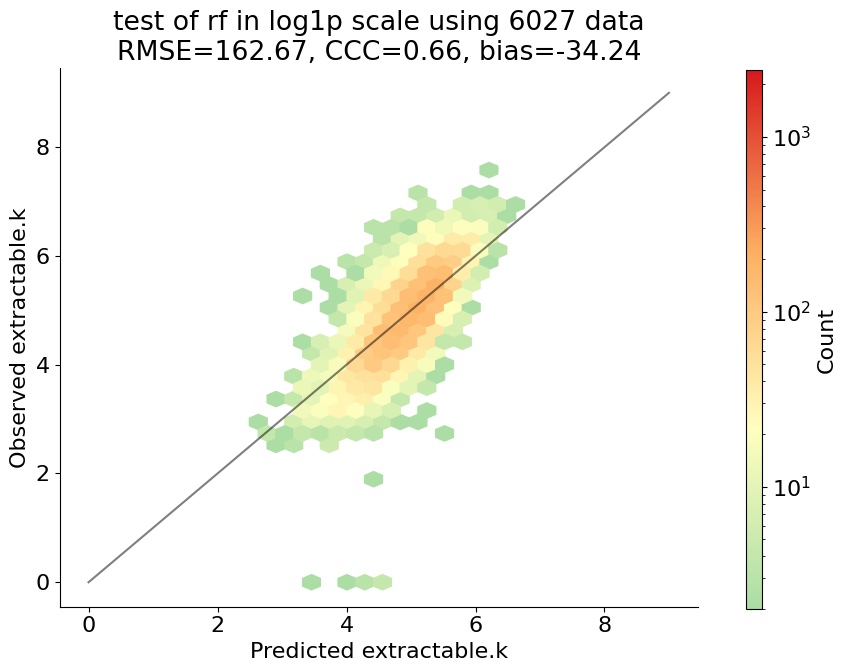

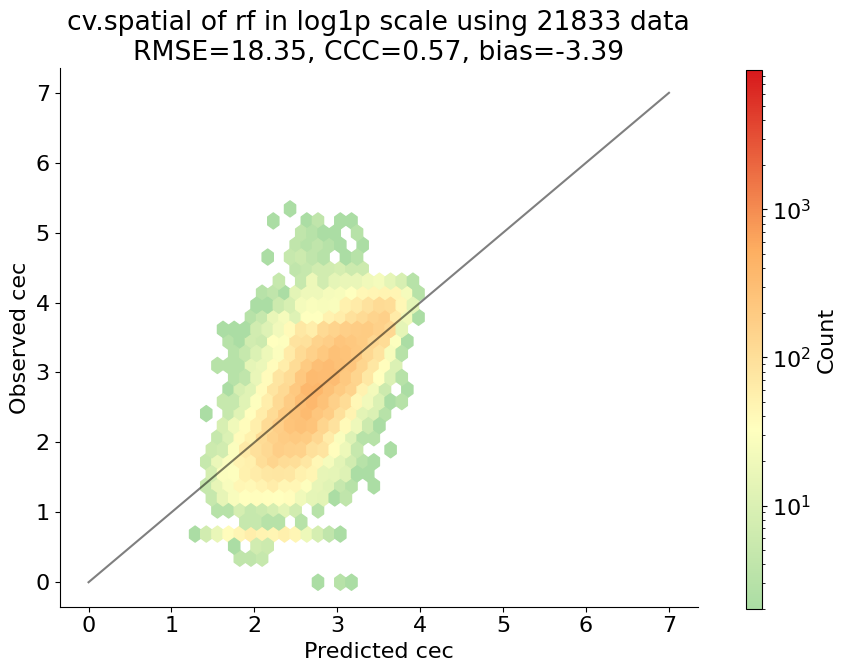

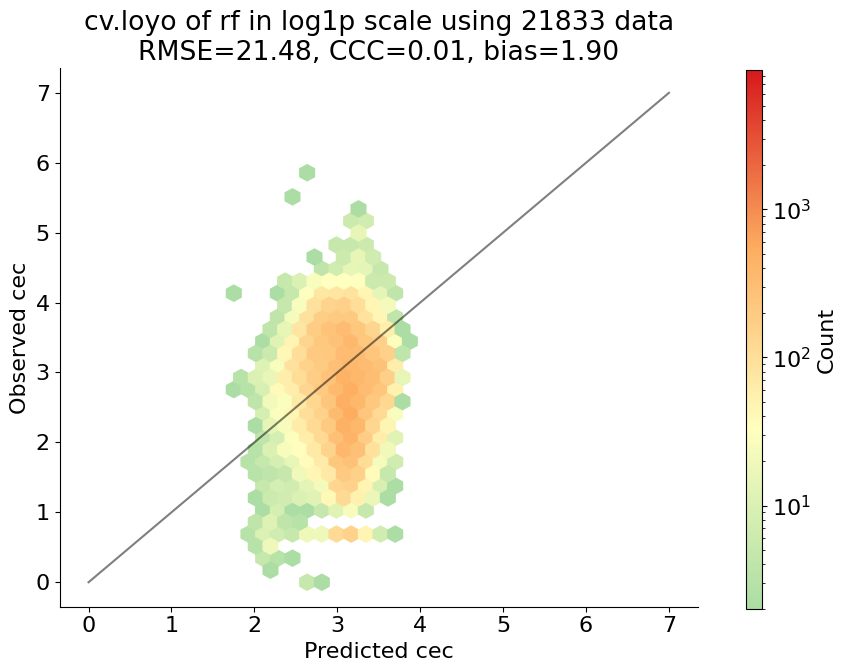

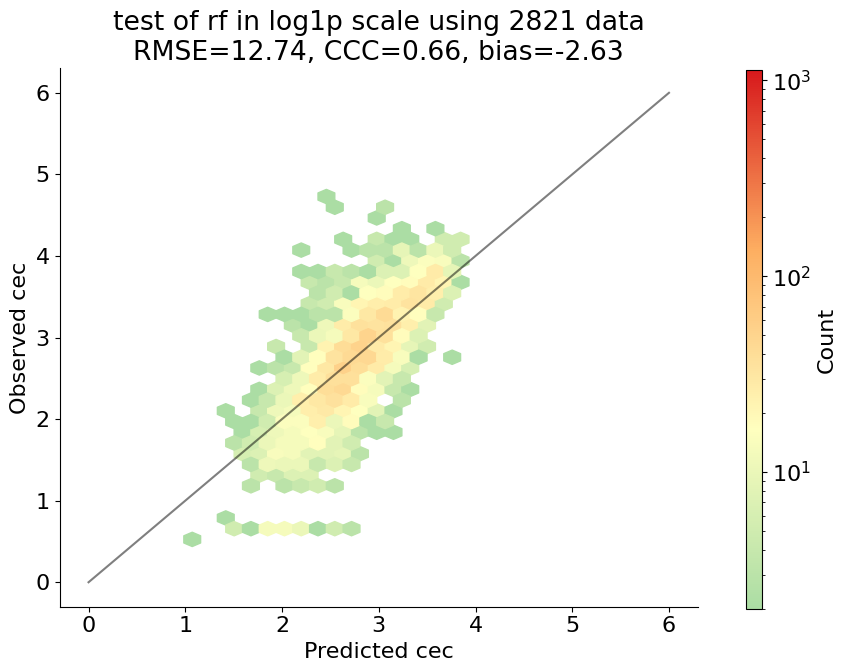

In [2]:
# general accuracy

results_cv = []

for ii in range(0,len(prop_list)):

    # define metadata------------------------------------------------------------
    prop = prop_list[ii]
    ttprint(f'processing {prop}-----------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read in data--------------------------------------------------------------
    train = pd.read_csv(f'{output_folder}/prediction_cv_{prop}_v{version}.csv')
    test = pd.read_csv(f'{output_folder}/prediction_test_{prop}_v{version}.csv')
    
    # accuracy plot
    model_list = find_files(data_path+f'/{prop}',f'*model*rf*{prop}*joblib')
    model_list = [str(i) for i in model_list]
    
    for iii in range(len(model_list)):
        mdl = model_list[iii].split('_')[-2].split('.')[0]
        for test_type in ['cv.spatial', 'cv.loyo']:
            for iicol in train.columns:
                if test_type in iicol:
                    cv_col = iicol
                    
            rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(train[tgt], train[cv_col], prop, space, mdl, test_type, data_path)
            results_cv.append({
                'prop':prop,
                'model': mdl,
                'evaluation_type': test_type,
                'RMSE': rmse,
                'MAE': mae,
                'MedAE': medae,
                'MAPE': mape,
                'R2': r2,
                'CCC': ccc,
                'bias': bias
            })
            
        for iicol in test.columns:
            if 'test' in iicol:
                tst_col = iicol
        rmse, mae, medae, mape, ccc, r2, bias = accuracy_plot(test[tgt], test[tst_col], prop, space, mdl, 'test', data_path)
        results_cv.append({
            'prop':prop,
            'model': mdl,
            'evaluation_type': 'test',
            'RMSE': rmse,
            'MAE': mae,
            'MedAE': medae,
            'MAPE': mape,
            'R2': r2,
            'CCC': ccc,
            'bias': bias
        })
        
    
results_cv = pd.DataFrame(results_cv)
results_cv.to_csv(f'{data_path}/metrics_all.prop.csv',index=False)

In [3]:
results_cv.to_csv(f'{data_path}/metrics_all.prop.csv',index=False)

### plot test accuracies by strata

In [5]:
bins = [0, 20, 50, 100, float('inf')]
labels = ['0-20', '20-50', '50-100', '>100']  

In [6]:
# strata accuracy

for ii in range(0,len(prop_list)):    
    prop = prop_list[ii]
    ttprint(f'processing {prop}-----------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    test = pd.read_csv(f'{output_folder}/prediction_test_{prop}_v{version}.csv')
    test['hzn_dep_bin'] = pd.cut(test['hzn_dep'], bins=bins, labels=labels, right=True)
    
    # accuracy plot
    model_list = find_files(data_path+f'/{prop}',f'*model*rf*{prop}*joblib')
    model_list = [str(i) for i in model_list]

    for iii in range(len(model_list)):
        mdl = model_list[iii].split('_')[-2].split('.')[0]
        
        stratified_results = []

        for clm in test['clm_class'].unique():
            for z_bin in test['hzn_dep_bin'].unique():
                subset = test[(test['clm_class'] == clm) & (test['hzn_dep_bin'] == z_bin)]

                if len(subset) == 0:
                    continue  # Skip if the subset is empty

                # y_val_strata = model.predict(subset[covs])
                y_val_strata = subset[f'{tgt}_test_{mdl}']
                rmse_val, mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(subset[tgt], y_val_strata, space=space)
                stratified_results.append({
                    'model': mdl,
                    'stratum_type': 'clm_class + hzn_dep_bin',
                    'clm_class': clm,
                    'hzn_dep_bin': z_bin,
                    'RMSE': rmse_val,
                    'MAE': mae_val,
                    'MAPE': mape_val,
                    'MedAE': medae_val,
                    'R2': np.nan if len(subset)<5 else r2_val,
                    'CCC': np.nan if len(subset)<5 else ccc_val,
                    'bias': bias_val,
                    'count': len(subset) 
                })
            
    stratified_results_df = pd.DataFrame(stratified_results)
    stratified_results_df.to_csv(f'{output_folder}/metrics_test.strata_{prop}.csv',index=False)
    

[14:33:21] processing bulk.density-----------------------------------
[14:33:21] processing ph.h2o-----------------------------------
[14:33:21] processing texture1-----------------------------------
[14:33:22] processing texture2-----------------------------------


In [7]:
prop = 'ocd'
mdl = 'rf'
stratified_results_df = pd.read_csv(f'{data_path}/{prop}/metrics_test.strata_{prop}.csv')
strata_df = stratified_results_df.loc[stratified_results_df['model'] == mdl]

In [8]:
import seaborn as sns
def accuracy_strata_plot(metric, strata_df, prop, mdl):

    plt.figure(figsize=(12, 10))
    pivot_data = strata_df.pivot(index='clm_class', columns='hzn_dep_bin', values=metric)

    pivot_data = pivot_data.reindex(['0-30', '30-60', '60-100', '>100'],axis=1)

    ax = sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".2f",
        cmap='autumn_r',
        cbar_kws={
            'shrink': 0.7, 
            'label': metric
        },
        annot_kws={"fontsize": 13},
        vmin = 1,
        vmax = 20
    )

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)  # Font size for colorbar ticks
    cbar.set_label(metric, size=14)  # Font size for colorbar label

    for i in range(pivot_data.shape[0] + 1):  # Horizontal grid lines
        ax.axhline(i, color='black', linewidth=1)
    for j in range(pivot_data.shape[1] + 1):  # Vertical grid lines
        ax.axvline(j, color='black', linewidth=1)

    ax.set_title(f'{prop}, {mdl}, {metric}', fontsize=14)
    ax.set_xlabel('Soil depth (cm)', fontsize=14)
    ax.set_ylabel('Climate class', fontsize=14)

    # ax.set_xticks(np.arange(len(pivot_data.columns)) + 0.7)
    ax.set_xticklabels(pivot_data.columns, fontsize=14) #, ha='right'
    ax.set_yticklabels(pivot_data.index, fontsize=14) #rotation=60,

    plt.tight_layout()
    plt.show()

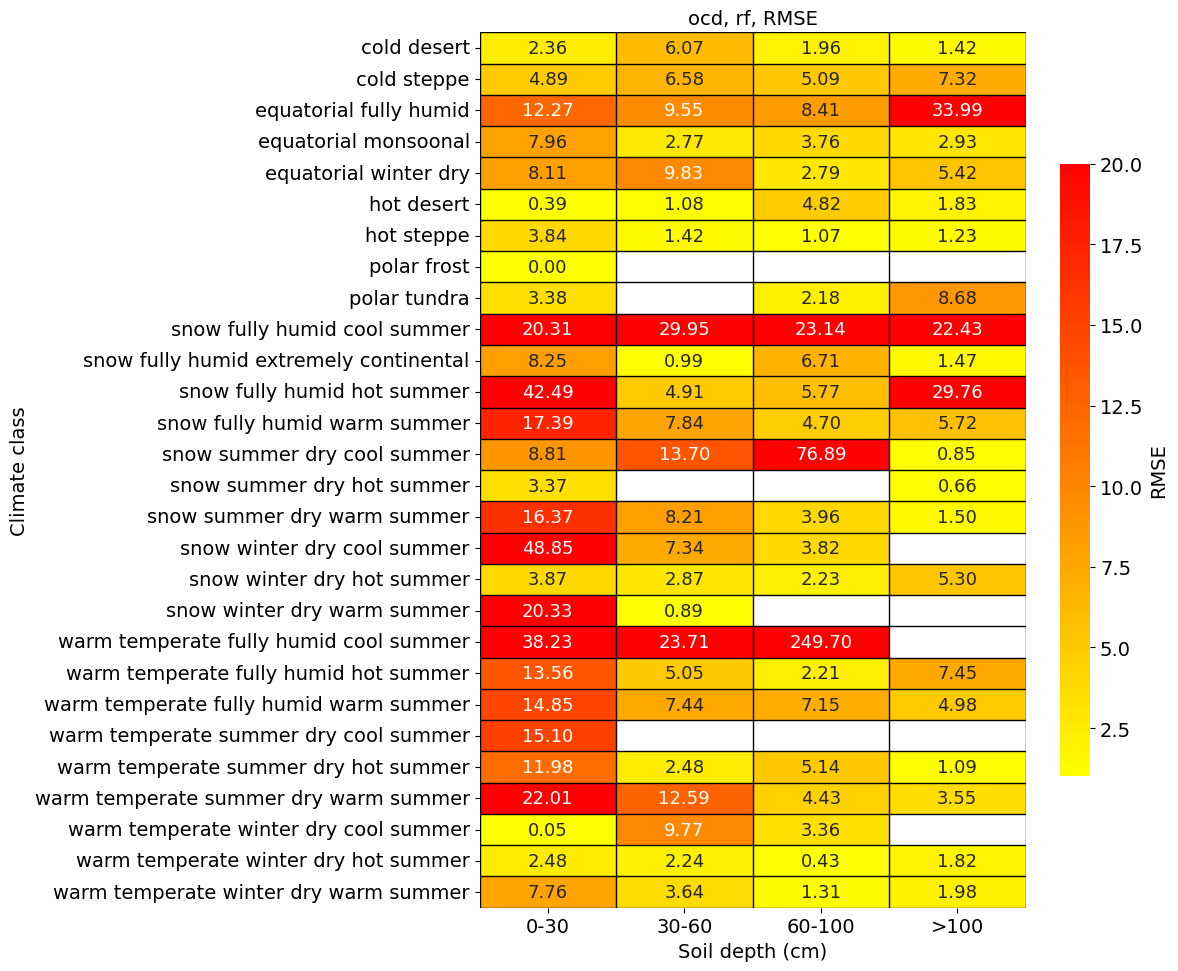

In [9]:

accuracy_strata_plot('RMSE', strata_df, prop, mdl)